<a href="https://www.kaggle.com/code/emadamani/notebook82a02f77e2?scriptVersionId=265692928" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install keras-facenet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.9 MB/s eta 0:00:00
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10367 sha256=c62bbef6f5962c8909531efbaeca53b017eb7a812d90d24e95d4d618383b8ba3
  Stored in directory: /root/.cache/pip/wheels/99/94/dd/cb1a65a7440ba6d508bd24346c15af0b1d24ff8b1cdb1c9959
Successfully built keras-facenet


# Librarys

In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models, optimizers, ops
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from tensorflow import keras
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import cv2
import os

2025-10-04 13:51:42.061329: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759585902.257153      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759585902.318427      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMAGE_SIZE = 160  # images & input size

#The names of the folders whose images we want to use for the query set and support set,
#and the model will not see these at the time of the train.
infrence_data = ['000009', '000032', '000046']

In [4]:
def process_image(image_path):
    
    image = tf.io.read_file(image_path)   
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 128.0
    return image

# read data

In [5]:
def path_label_imags(base_dir):
    images_paths = []
    labels = []

    label = 0
    for folder in os.listdir(base_dir):
        
        if folder in infrence_data:
            continue
        
        files_path = os.path.join(base_dir, folder)
        
        for file in os.listdir(files_path):
            image_path = os.path.join(files_path, file)
            
            images_paths.append(image_path)
            labels.append(label)
            
        label+=1
            
    return images_paths, labels
        
    
base_dir = "/kaggle/input/casia-face-dataset/casia dataset"
images_path, labels = path_label_imags(base_dir)
print(len(images_path), len(labels))
print(f'Total Labels :{len(set(labels))}')

19894 19894
Total Labels :197


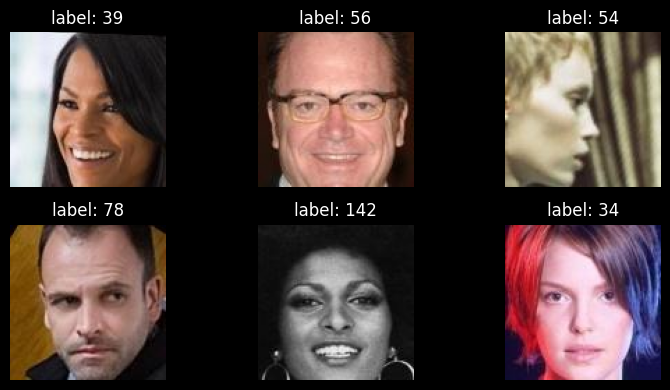

In [6]:
def open_img(img_paath):
    return cv2.imread(img_paath)[:,:,::-1]

plt.figure(figsize=(8, 4))

for i in range(6):
    random_idx = np.random.randint(len(images_path))
    plt.subplot(2, 3, i+1)   
    plt.imshow(open_img(images_path[random_idx]))
    plt.axis("off")
    plt.title(f'label: {labels[random_idx]}')

plt.tight_layout()
plt.show()

# create paires data

In [7]:
def create_paires(data, labels):
    labels = np.array(labels)
    pairs_data = []
    pair_labels = []

    for idx in range(len(data)):
        ancher_data = data[idx]
        ancher_label = labels[idx]

        # positive pair (different from anchor itself)
        pos_candidates = np.where(labels == ancher_label)[0]
        pos_candidates = pos_candidates[pos_candidates != idx]
        if len(pos_candidates) > 0:
            pos_idx = np.random.choice(pos_candidates)
            pos_data = data[pos_idx]
            pairs_data.append([ancher_data, pos_data])
            pair_labels.append(0) # ---> similar (positive pair)

        # negative pair
        neg_candidates = np.where(labels != ancher_label)[0]
        neg_idx = np.random.choice(neg_candidates)
        neg_data = data[neg_idx]
        pairs_data.append([ancher_data, neg_data])
        pair_labels.append(1) # ---> dissimilar (negative pair)

    return pairs_data, pair_labels

39788 39788
Number of positive pairs 19894
Number of negative pairs 19894
[['/kaggle/input/casia-face-dataset/casia dataset/000521/00050240.jpg', '/kaggle/input/casia-face-dataset/casia dataset/000521/00050224.jpg'], ['/kaggle/input/casia-face-dataset/casia dataset/000521/00050240.jpg', '/kaggle/input/casia-face-dataset/casia dataset/000257/00031308.jpg'], ['/kaggle/input/casia-face-dataset/casia dataset/000521/00050174.jpg', '/kaggle/input/casia-face-dataset/casia dataset/000521/00050271.jpg']]


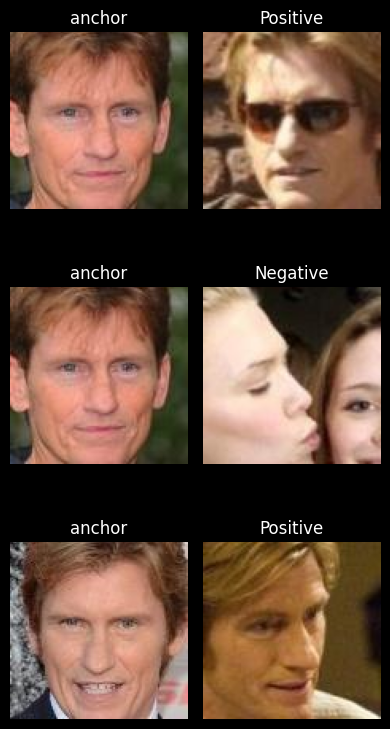

In [8]:
pairs_data, pair_labels = create_paires(images_path, labels)
print(len(pairs_data), len(pair_labels))
print('Number of positive pairs',pair_labels.count(0))
print('Number of negative pairs',pair_labels.count(1))


paris_sample = [pairs_data[idx] for idx in range(800, 803)]
labels_sample = [pair_labels[idx] for idx in range(800, 803)]
print(paris_sample)

plt.figure(figsize=(4, 8))
j=0
for n, i in enumerate(paris_sample):
    j+=1
    plt.subplot(3, 2, j)   
    plt.imshow(open_img(i[0]))
    plt.axis("off")
    plt.title(f'anchor')

    j+=1
    plt.subplot(3, 2, j)   
    plt.imshow(open_img(i[1]))
    plt.axis("off")
    if labels_sample[n] == 0:
        plt.title('Positive')
    else:
        plt.title('Negative')


plt.tight_layout()
plt.show()

# Converting data to TensorFlow datasets and image processing

In [9]:
def data_loder(pairs_data, pair_labels):
    
    L_img = [p[0] for p in pairs_data]
    R_img = [p[1] for p in pairs_data]
    
    dataset = tf.data.Dataset.from_tensor_slices(((L_img, R_img), pair_labels))
    
    def preprocess(x, y):
        x1, x2 = x
        
        x1 = process_image(x1)
        x2 = process_image(x2)
        return ((x1, x2), y)
    
    dataset = dataset.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

    return dataset

# train test split

In [10]:
dataset = data_loder(pairs_data, pair_labels)

dataset_size = dataset.cardinality().numpy()   
train_size = int(0.8 * dataset_size)   

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

print(len(train_dataset))
print(len(val_dataset))

I0000 00:00:1759585921.065357      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759585921.066029      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


995
249


# Feature extraction network from images(Embedding image)

In [11]:
def backbone(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):

    embedder = FaceNet()
    base_model = embedder.model 
    
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Dense(64, activation='relu')(base_model.output)
    x = layers.Dropout(0.7)(x)
    x = layers.Dense(32, activation='relu')(x)
    
    x = layers.Lambda(lambda t: tf.math.l2_normalize(t, axis=1))(x)

    feature_extractor = models.Model(inputs=base_model.input, outputs=x)
    
    print("Feature extractor (FaceNet) model has been successfully built.")
    return feature_extractor

# euclidean_distance / loss(contrastive loss)

In [12]:
def euclidean_distance(vectors):
    x, y = vectors
    sum_square = ops.sum(ops.square(x-y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))


def loss(margin=1):
    def contrastive_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        square_pred = ops.square(y_pred)
        margine_squar = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1-y_true)*square_pred + (y_true)*margine_squar)
        
    return contrastive_loss

# siamese network

In [13]:
def siamese(image_size=(IMAGE_SIZE, IMAGE_SIZE, 3)):
    feature_extractor = backbone()
    
    input1 = layers.Input(image_size)
    input2 = layers.Input(image_size)
    
    network1 = feature_extractor(input1)
    network2 = feature_extractor(input2)
    
    distance = layers.Lambda(euclidean_distance, output_shape=(1,))([network1, network2])
    
    model = models.Model(inputs = [input1, input2], outputs = distance)

    return model

In [14]:
siamese_model = siamese()
siamese_model.compile(loss=loss(margin=1.0), optimizer="RMSprop", metrics=["accuracy"])
siamese_model.summary()

Feature extractor (FaceNet) model has been successfully built.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 32)        │ 23,532,336 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_22 (Lambda)  │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,532,336 (89.77 MB)

 Trainable params: 34,912 (136.38 KB)

 Non-trainable params: 23,497,424 (89.64 MB)

In [15]:
history = siamese_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
)

Epoch 1/5


I0000 00:00:1759585953.352986      75 service.cc:148] XLA service 0x7a75d4096780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759585953.354114      75 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1759585953.354150      75 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1759585958.352349      75 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/995 ━━━━━━━━━━━━━━━━━━━━ 11:01:04 40s/step - accuracy: 0.4062 - loss: 0.5994

I0000 00:00:1759585965.467735      75 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


995/995 ━━━━━━━━━━━━━━━━━━━━ 163s 124ms/step - accuracy: 0.6398 - loss: 0.2368 - val_accuracy: 0.7904 - val_loss: 0.1422
Epoch 2/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 115s 115ms/step - accuracy: 0.7723 - loss: 0.1593 - val_accuracy: 0.8145 - val_loss: 0.1326
Epoch 3/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 116s 116ms/step - accuracy: 0.7938 - loss: 0.1468 - val_accuracy: 0.8193 - val_loss: 0.1293
Epoch 4/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 114s 114ms/step - accuracy: 0.7979 - loss: 0.1431 - val_accuracy: 0.8225 - val_loss: 0.1271
Epoch 5/5
995/995 ━━━━━━━━━━━━━━━━━━━━ 111s 111ms/step - accuracy: 0.8090 - loss: 0.1394 - val_accuracy: 0.8252 - val_loss: 0.1261


---

# Inference Data Preparation: Query and Support Sets

In the variable infrence_data, we randomly selected folder names. The model is not allowed to see or learn from the data inside these three folders during training. Later, we use the images from these folders for evaluation, treating them as the query set and support set.

From each of these three folders, we picked six images: one image as part of the query set, and the remaining five images as the support set. This setup is similar to a scenario where five different users each provide five images of themselves to the system.

Thus, from these three folders, we obtained 15 support images (5 from each folder). We then built a small dataset from these 15 images. By pairing these 15 images, we obtained 30 image pairs in total, and we performed an additional small training step on the model using them.

Finally, we used the query set (3 images in total — one from each folder). These query images have never been seen by the model during training. Each query image is paired with every image in the support set, and the model outputs the similarity score for each pair.

At the end, the pairs of images with the lowest contrastive loss values are considered the most similar matches.

15
15
3
support set


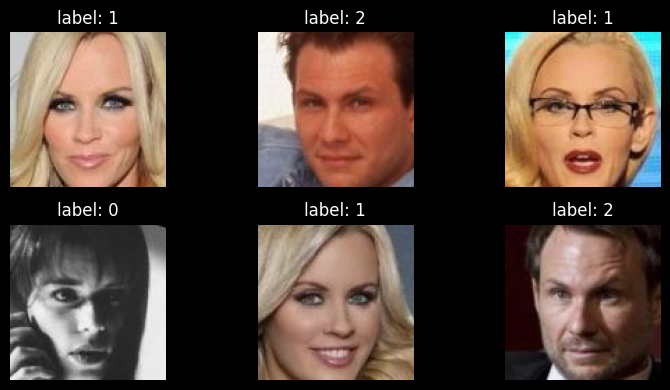

quary set


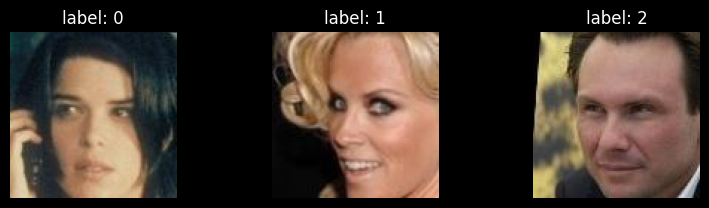

In [16]:
#infrence_data = ['000009', '000032', '000046']
base_dir = "/kaggle/input/casia-face-dataset/casia dataset"
support_set_data=[]
support_set_label=[]

query_set={}

for i, folder in enumerate(infrence_data):
    folder_path = os.path.join(base_dir, folder)
    files=[]
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        files.append(file_path)
        
    items=np.random.choice(len(files), 6, replace=False)

    # query_set
    query_set[i]=files[items[0]]
    # support_set
    for f in items[1:]:
        support_set_data.append(files[f])
        support_set_label.append(i)
    
print(len(support_set_data))
print(len(support_set_label))
print(len(query_set))

print('support set')
plt.figure(figsize=(8, 4))
res= np.random.choice(['a', 'b', 'c'], size=2, replace=False)

indexs = random.sample(range(0, len(support_set_data)), 6)
for i in range(6):
    random_idx = indexs[i]
    plt.subplot(2, 3, i+1)   
    plt.imshow(open_img(support_set_data[random_idx]))
    plt.axis("off")
    plt.title(f'label: {support_set_label[random_idx]}')

plt.tight_layout()
plt.show()

print('quary set')
plt.figure(figsize=(8, 4))
for i in range(len(query_set)):
    random_idx = np.random.randint(len(images_path))
    plt.subplot(2, 3, i+1) 
    plt.imshow(open_img(query_set[i]))
    plt.axis("off")
    plt.title(f'label: {i}')

plt.tight_layout()
plt.show()

# pair data > support set

30
30


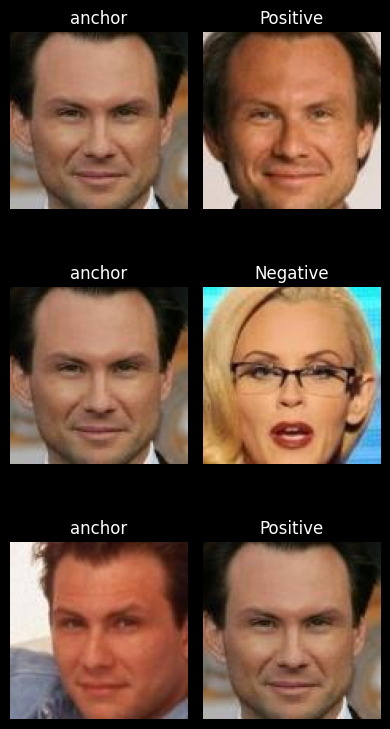

In [17]:
pair_data_supp, pair_label_supp = create_paires(support_set_data, support_set_label)
print(len(pair_data_supp))
print(len(pair_label_supp))

plt.figure(figsize=(4, 8))
j=0
for n, i in enumerate(pair_data_supp[20:23]):
    j+=1
    plt.subplot(3, 2, j) 
    plt.imshow(open_img(i[0]))
    plt.axis("off")
    plt.title(f'anchor')

    j+=1
    plt.subplot(3, 2, j)  
    plt.imshow(open_img(i[1]))
    plt.axis("off")
    if pair_label_supp[n] == 0:
        plt.title('Positive')
    else:
        plt.title('Negative')


plt.tight_layout()
plt.show()

In [18]:
support_dataset = data_loder(pair_data_supp, pair_label_supp)

# train with support set data

In [19]:
history_support = siamese_model.fit(
    support_dataset,
    epochs=20,
)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9333 - loss: 0.0889
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9333 - loss: 0.1035
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0758
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9333 - loss: 0.0789
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9667 - loss: 0.0508
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9667 - loss: 0.0654
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9333 - loss: 0.0580
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9333 - loss: 0.0625
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 1.0000 - loss: 0.0343
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9667 - loss: 0.0460
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 1.0000 - loss: 0.0442
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss

item 0 from Query set
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
item 1 from Query set
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━

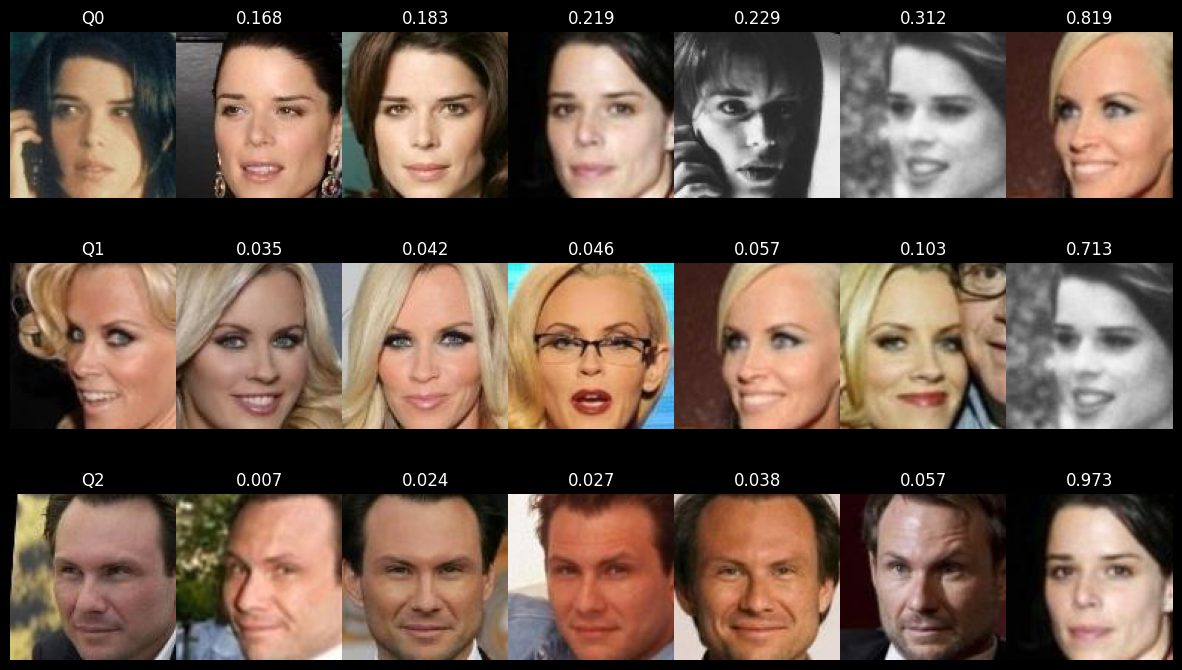

In [20]:
result = []
for q in range(len(query_set)):
    print(f'item {q} from Query set')
    query = np.expand_dims(process_image(query_set[q]), axis=0)
    distances = []
    for i, s in enumerate(support_set_data):
        support = np.expand_dims(process_image(s), axis=0)
        distance = siamese_model.predict([query, support])
        distances.append([q, support_set_label[i], distance, s])
        
    x = sorted(distances, key=lambda a : a[2])
    result.append(x)

################################################## imshow

plt.figure(figsize=(15, 3*len(result))) 

for idx, x in enumerate(result):

    plt.subplot(len(result), 7, idx*7 + 1)
    plt.imshow(open_img(query_set[idx]))
    plt.axis("off")
    plt.title(f'Q{idx}')
    

    for i in range(6):
        plt.subplot(len(result), 7, idx*7 + i + 2)
        plt.imshow(open_img(x[i][3]))
        plt.axis("off")
        plt.title(round(x[i][2][0][0], 3))

plt.subplots_adjust(wspace=0, hspace=0)  

# ✅️⚠️ Attention: Query vs. Support Image Distances
In this plot, the query image is displayed on the left. For each query image, there are 5 corresponding support images from the same class. The model has successfully recognized these support images, producing very small distances between them and the query image. The distances are sorted from the smallest to the largest, clearly showing the similarity ranking.

Each row contains 7 images:

The first image is the query image.

The next 5 images are the support images from the same class as the query, which the model correctly identified with very small distances.

The seventh (last) image is unrelated to the query class. This image demonstrates that the model assigns a much larger distance to a dissimilar image, showing that it can effectively distinguish between similar and dissimilar images.

Overall, this plot clearly illustrates that the model can find the most similar and relevant images, assign small distances to them, assign large distances to unrelated images, and sort all images in ascending order of distance.

---